In [2]:
%reload_ext autoreload
%autoreload 2

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as trans

import torch

import os
import sys

sys.path.append('../')
sys.path.append('code/')

from cross_subject_testing import god_bold_test

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [3]:
plt.style.use('seaborn-v0_8-paper')

from cycler import cycler
colors = cycler('color', ['#e63946', '#006699', '#fcd581', '#a1c349', '#ff9ebb', '#C2BBF0', '#f27f34', '#48631d', '#55bbee', '#B2BFB5'])

plt.rc('figure', dpi=200, figsize=(10,90/16))
plt.rc('font', size=12, weight=500)
plt.rc('lines', linewidth=2)
# no edges
plt.rc('axes', facecolor='FAFAFA', axisbelow=True, grid=True, prop_cycle=colors, edgecolor='white', labelcolor='dimgrey')
# set grid lines to be thinner
plt.rc('grid', color='D1D1D1', linestyle='-', linewidth=0.7)
# legend edge color
plt.rc('legend', edgecolor='D1D1D1')

# get cycler color
def get_color(i):
    return str(plt.rcParams['axes.prop_cycle'].by_key()['color'][i])

#### Same subject testing

In [4]:
metrics_path = 'results/tests'

seeds = [0,1,2,3,4]
nolinear_files = [f'maxout_seed{seed}_nolinearCRL.pkl' for seed in [0,1,2,3]]
bare_files = [f'bare_seed{seed}_standard.pkl' for seed in seeds]
cross_files = [f'bare2_seed{seed}_standard.pkl' for seed in seeds]
mlp_files = [f'mlp_seed{seed}_standard.pkl' for seed in seeds]
maxout_files = [f'maxout_seed{seed}_standard.pkl' for seed in seeds]
relu_files = [f'relu_seed{seed}_standard.pkl' for seed in seeds]
lat_10_files = [f'maxout_seed{seed}_latdim10.pkl' for seed in [0]]
lat_100_files = [f'maxout_seed{seed}_latdim100.pkl' for seed in [0]]

nolinear_data = []
bare_data = []
cross_data = []
mlp_data = []
maxout_data = []
relu_data = []
lat_10_data = []
lat_100_data = []

for files, data in zip([nolinear_files, bare_files, cross_files, mlp_files, maxout_files, relu_files, lat_10_files, lat_100_files], [nolinear_data, bare_data, cross_data, mlp_data, maxout_data, relu_data, lat_10_data, lat_100_data]):
    for file in files:
        with open(os.path.join(metrics_path, file), 'rb') as f:
            data.append(pickle.load(f))

In [83]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', linestyle=None, **kwargs):
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        linestyle=linestyle,
        linewidth=1,
        **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = trans.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

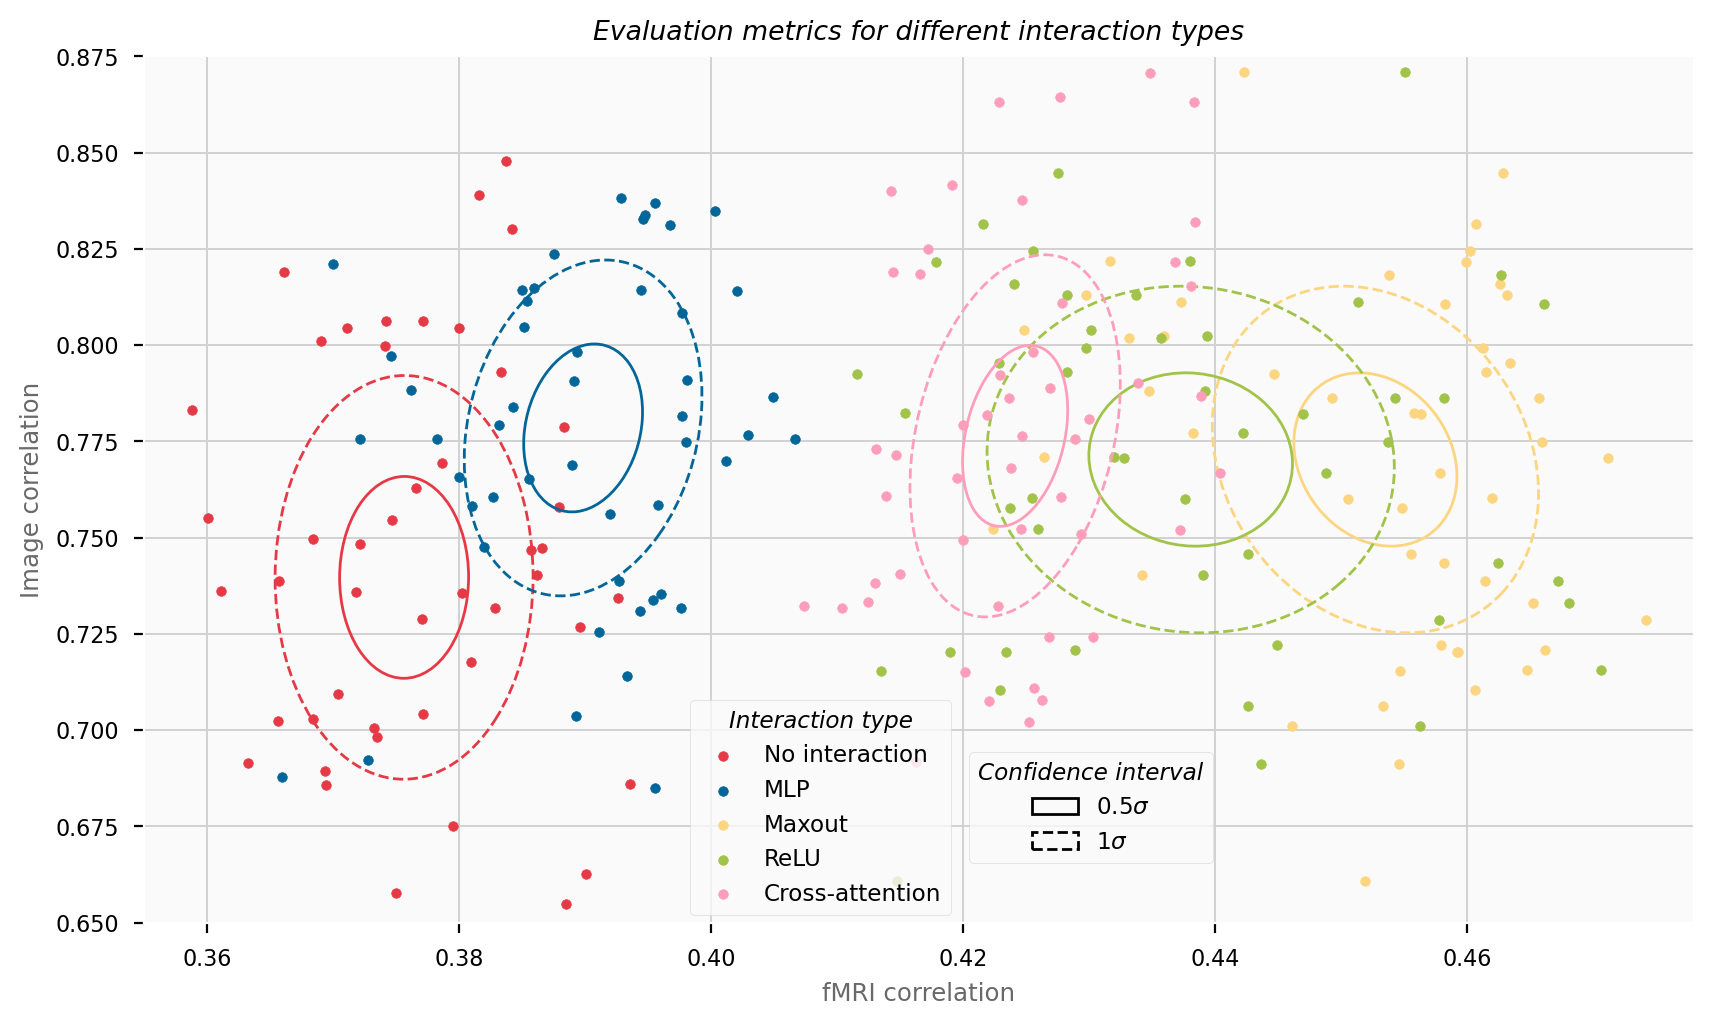

In [165]:
# we use the latter 25% of the training, once the model has converged

fig, ax = plt.subplots()

for i,data in enumerate([bare_data, mlp_data, maxout_data, relu_data, cross_data]):
    start_i = 10 if i == 0 else 30
    stop_i = 20 if i == 0 else 40
    m = np.array([data[i]['eval_metrics'][start_i:stop_i,0:2] for i in range(len(data))]).reshape(-1,2)
    x = m[:,0]
    y = m[:,1]

    ax.scatter(x, y, s=12, color=get_color(i), label=str(i))
    confidence_ellipse(x, y, ax, edgecolor=get_color(i), linestyle='-', n_std=0.5)
    confidence_ellipse(x, y, ax, edgecolor=get_color(i), linestyle='--', n_std=1)

plt.xlim(0.355, 0.478)
plt.ylim(0.65, 0.875)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['No interaction', 'MLP', 'Maxout', 'ReLU', 'Cross-attention'], loc='upper left', bbox_to_anchor=(0.345, 0.27), title='Interaction type', fontsize='x-small', title_fontproperties={'style':'italic', 'size':'x-small'})
ax.add_artist(legend)

# add a second legend for the ellipses to the right of the first one
# continuous line, dashed line
handles = [Ellipse((0,0), 1, 1, edgecolor='black', linestyle='-', linewidth=1, facecolor='none'), Ellipse((0,0), 1, 1, edgecolor='black', linestyle='--', linewidth=1, facecolor='none')]
ax.legend(handles, [r'$0.5 \sigma$', r'$1 \sigma$'], title='Confidence interval', fontsize='x-small', title_fontproperties={'style':'italic', 'size':'x-small'}, loc='upper left', bbox_to_anchor=(0.525, 0.21))

plt.title('Evaluation metrics for different interaction types', style='italic')
plt.xlabel('fMRI correlation')
plt.ylabel('Image correlation')

plt.show()

In [ ]:
s = 30

from scipy.stats import f_oneway

m1 = 2*np.array([cross_data[i]['eval_metrics'][s:,0] for i in range(5)]).reshape(-1) + np.array([cross_data[i]['eval_metrics'][s:,1] for i in range(5)]).reshape(-1)
m2 = 2*np.array([maxout_data[i]['eval_metrics'][s:,0] for i in range(5)]).reshape(-1) + np.array([maxout_data[i]['eval_metrics'][s:,1] for i in range(5)]).reshape(-1)
m4 = 2*np.array([relu_data[i]['eval_metrics'][s:,0] for i in range(5)]).reshape(-1) + np.array([relu_data[i]['eval_metrics'][s:,1] for i in range(5)]).reshape(-1)

print("ANOVA test results:")
print()
print('Cross-attention vs Maxout', f_oneway(m1, m2).pvalue, '***' if f_oneway(m1, m2)[1] < 0.001 else '**' if f_oneway(m1, m2)[1] < 0.01 else '*' if f_oneway(m1, m2)[1] < 0.05 else '')
print('Cross-attention vs ReLU', f_oneway(m1, m4).pvalue, '***' if f_oneway(m1, m4)[1] < 0.001 else '**' if f_oneway(m1, m4)[1] < 0.01 else '*' if f_oneway(m1, m4)[1] < 0.05 else '')
print('ReLU vs Maxout', f_oneway(m2, m4).pvalue, '***' if f_oneway(m2, m4)[1] < 0.001 else '**' if f_oneway(m2, m4)[1] < 0.01 else '*' if f_oneway(m2, m4)[1] < 0.05 else '')

ANOVA test results:

Cross-attention vs Maxout 2.371355957527118e-06 ***
Cross-attention vs ReLU 0.04776639219550158 *
ReLU vs Maxout 0.00485762649832196 **


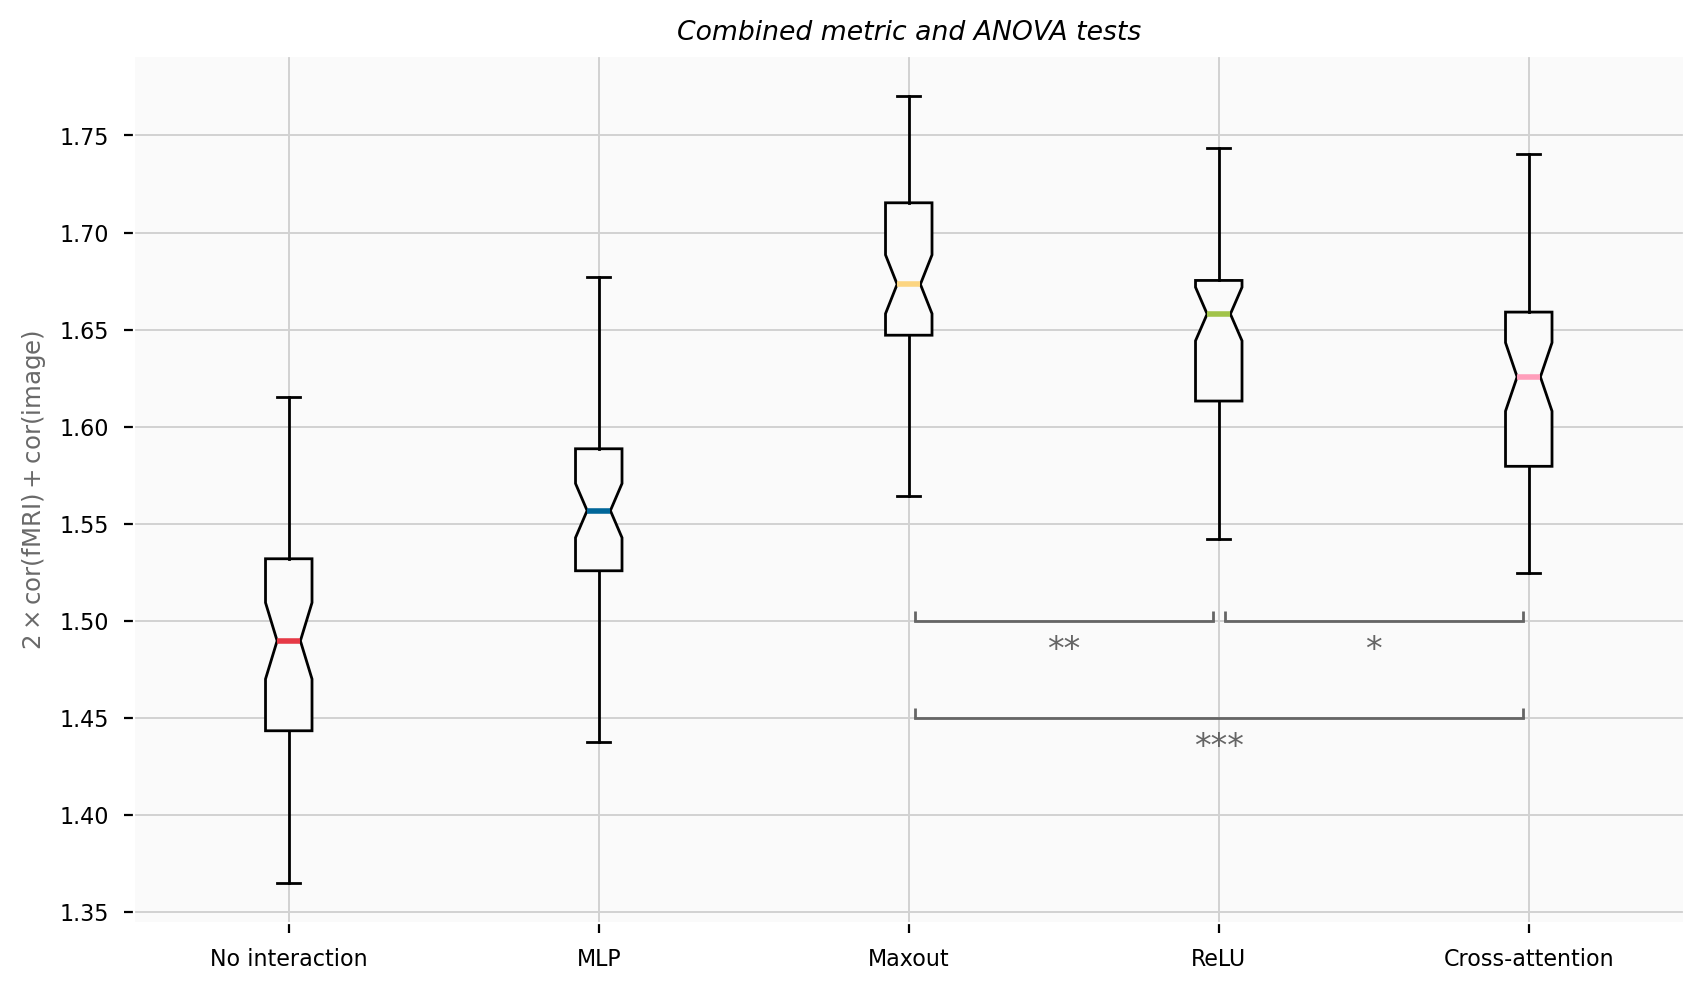

In [146]:
# we define the value of the ae model as 2*fmri_corr + img_corr, and then plot the distribution of this value for each model

fig, ax = plt.subplots(figsize=(10,90/16))

for i,data in enumerate([bare_data, mlp_data, maxout_data, relu_data, cross_data]):
    start_i = 10 if i == 0 else 30
    stop_i = 20 if i == 0 else 40
    
    m = np.array([data[i]['eval_metrics'][start_i:stop_i,0:2] for i in range(len(data))]).reshape(-1,2)
    x = m[:,0]
    y = m[:,1]
    ax.boxplot(2*x + y, positions=[i], showfliers=False, notch=True, patch_artist=True, medianprops={'linewidth':2, 'color':get_color(i)}, boxprops={'facecolor':'#FAFAFA'}, )

# add lines with *** to represent the ANOVA test results
ax.plot([2.02,2.98], [1.5,1.5], color='#656565', linestyle='-', linewidth=1)
ax.vlines(2.02, 1.5, 1.505, color='#656565', linestyle='-', linewidth=1)
ax.vlines(2.98, 1.5, 1.505, color='#656565', linestyle='-', linewidth=1)
ax.text(2.5, 1.485, '**', fontsize=12, ha='center', va='center', color='#656565')

ax.plot([3.02,3.98], [1.5,1.5], color='#656565', linestyle='-', linewidth=1)
ax.vlines(3.02, 1.5, 1.505, color='#656565', linestyle='-', linewidth=1)
ax.vlines(3.98, 1.5, 1.505, color='#656565', linestyle='-', linewidth=1)
ax.text(3.5, 1.485, '*', fontsize=12, ha='center', va='center', color='#656565')

ax.plot([2.02,3.98], [1.45,1.45], color='#656565', linestyle='-', linewidth=1)
ax.vlines(2.02, 1.45, 1.455, color='#656565', linestyle='-', linewidth=1)
ax.vlines(3.98, 1.45, 1.455, color='#656565', linestyle='-', linewidth=1)
ax.text(3, 1.435, '***', fontsize=12, ha='center', va='center', color='#656565')

plt.title('Combined metric and ANOVA tests', style='italic')
# use latex in label
plt.ylabel(r'$2 \times \text{cor(fMRI)} + \text{cor(image)}$')
plt.xticks([0,1,2,3,4], ['No interaction', 'MLP', 'Maxout', 'ReLU', 'Cross-attention'])
plt.show()

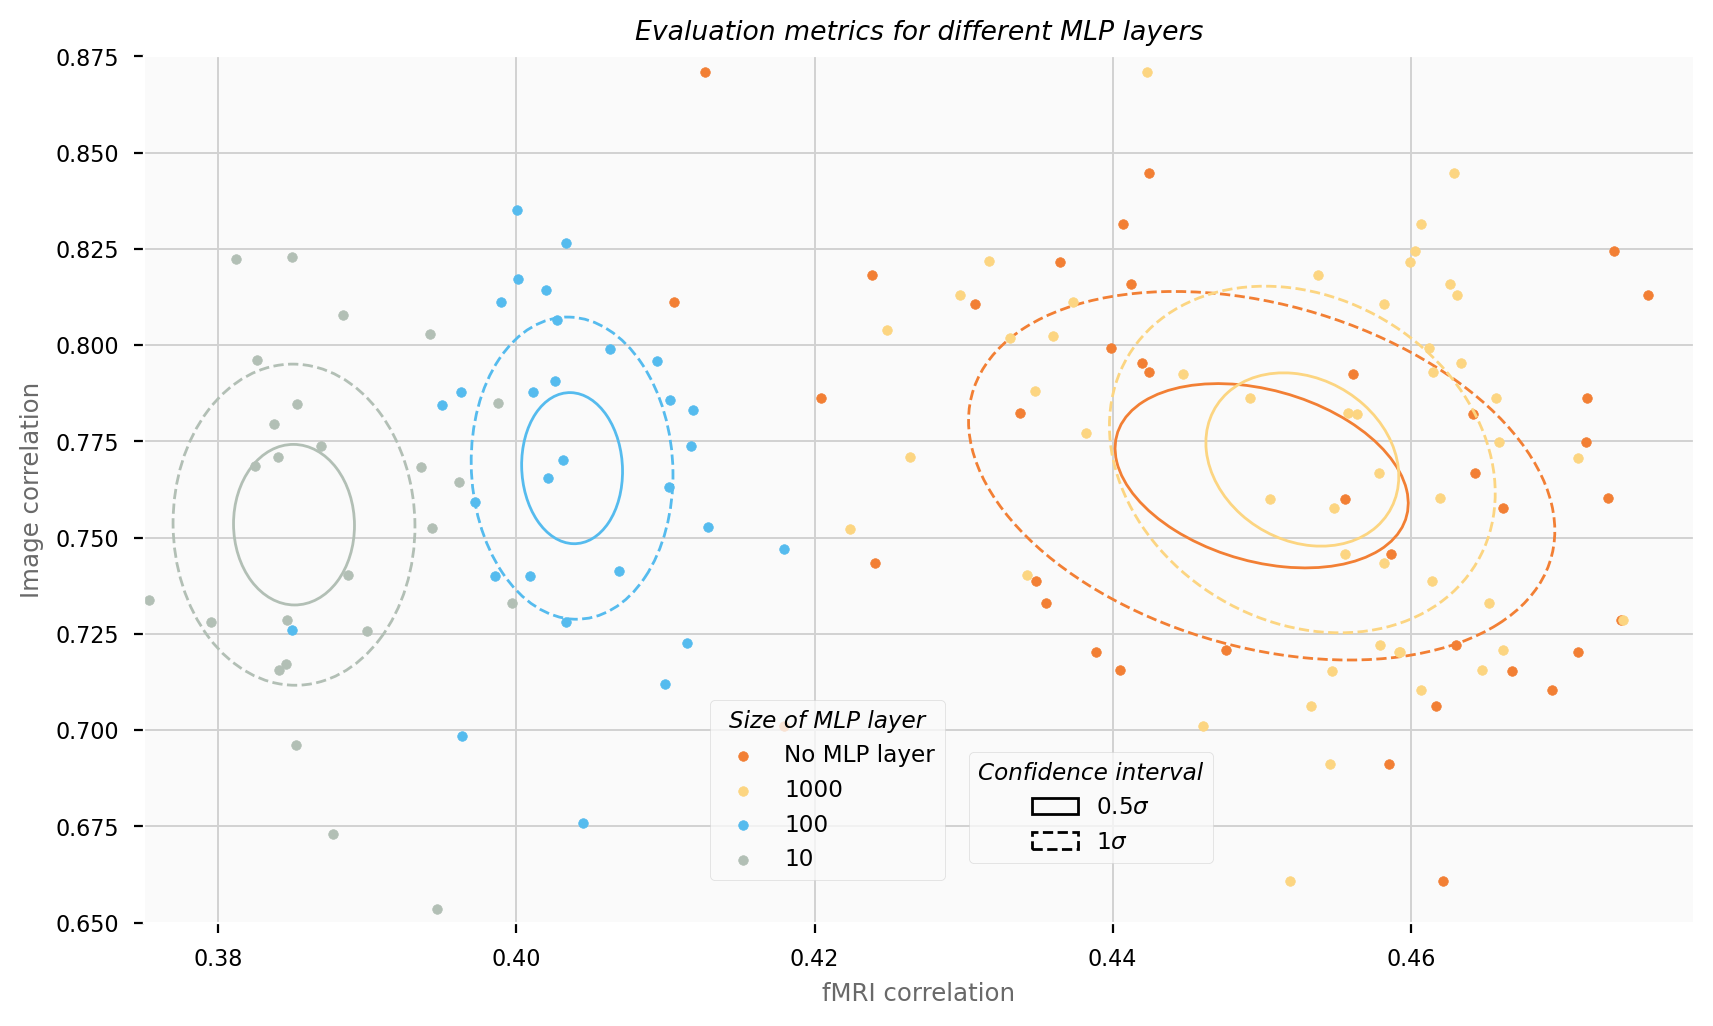

In [209]:
# maxout vs no-linear vs lat10 and lat100

fig, ax = plt.subplots()
def o(i):
    order = [6,2,8,9]
    return order[i]

for i,data in enumerate([nolinear_data, maxout_data, lat_100_data, lat_10_data]):
    start_i = 10 if i == 2 or i == 3 else 30
    stop_i = 40
    m = np.array([data[i]['eval_metrics'][start_i:stop_i,0:2] for i in range(len(data))]).reshape(-1,2)
    x = m[:,0]
    y = m[:,1]

    ax.scatter(x, y, s=12, color=get_color(o(i)), label=str(i))
    confidence_ellipse(x, y, ax, edgecolor=get_color(o(i)), linestyle='-', n_std=0.5)
    confidence_ellipse(x, y, ax, edgecolor=get_color(o(i)), linestyle='--', n_std=1)

plt.xlim(0.375, 0.479)
plt.ylim(0.65, 0.875)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['No MLP layer', '1000', '100', '10'], loc='upper left', bbox_to_anchor=(0.358, 0.27), title='Size of MLP layer', fontsize='x-small', title_fontproperties={'style':'italic', 'size':'x-small'})
ax.add_artist(legend)

# add a second legend for the ellipses to the right of the first one
# continuous line, dashed line
handles = [Ellipse((0,0), 1, 1, edgecolor='black', linestyle='-', linewidth=1, facecolor='none'), Ellipse((0,0), 1, 1, edgecolor='black', linestyle='--', linewidth=1, facecolor='none')]
ax.legend(handles, [r'$0.5 \sigma$', r'$1 \sigma$'], title='Confidence interval', fontsize='x-small', title_fontproperties={'style':'italic', 'size':'x-small'}, loc='upper left', bbox_to_anchor=(0.525, 0.21))

plt.title('Evaluation metrics for different MLP layers', style='italic')
plt.xlabel('fMRI correlation')
plt.ylabel('Image correlation')

plt.show()

In [216]:
m0 = 2*np.array([maxout_data[i]['eval_metrics'][s:,0] for i in range(5)]).reshape(-1) + np.array([maxout_data[i]['eval_metrics'][s:,1] for i in range(5)]).reshape(-1)
m1 = 2*np.array([nolinear_data[i]['eval_metrics'][s:,0] for i in range(4)]).reshape(-1) + np.array([nolinear_data[i]['eval_metrics'][s:,1] for i in range(4)]).reshape(-1)

print("ANOVA test results:")
print()
print('Linear vs no linear layer', f_oneway(m0, m1).pvalue, '***' if f_oneway(m0, m1)[1] < 0.001 else '**' if f_oneway(m0, m1)[1] < 0.01 else '*' if f_oneway(m0, m1)[1] < 0.05 else '')

ANOVA test results:

Linear vs no linear layer 0.3592890376979002 


#### Cross-subject

In [5]:
# CRL trained, best maxout model

model_path = 'results/fmri_finetune_GOD_sbj_1/11-07-2024-16-49-59/checkpoints_37/checkpoint_models.pth'
config_path = 'results/fmri_finetune_GOD_sbj_1/11-07-2024-16-49-59/checkpoints_37/checkpoint_cross_att_GOD_s_fmriw1.0_imgw1.0_fmar0.75_imar0.75.pth'

god_st, bold_st = god_bold_test(model_path, config_path)

/home/aip/dufly/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/aip/dufly/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Dataset: GOD
Dataset: GOD
Dataset: GOD
Dataset: GOD
Dataset: GOD


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Subject 1
Train
[Test 0] Test loss/corr fMRI: 0.407 | 0.720
           Test loss/corr image: 3.431e-04 | 0.841
Epoch end, total time: 0:51
Test
[Test 0] Test loss/corr fMRI: 0.056 | 0.476
           Test loss/corr image: 3.373e-04 | 0.839
Epoch end, total time: 0:53
Subject 2
Train
[Test 0] Test loss/corr fMRI: 0.845 | 0.481
           Test loss/corr image: 3.432e-04 | 0.839
Epoch end, total time: 1:42
Test
[Test 0] Test loss/corr fMRI: 0.067 | 0.466
           Test loss/corr image: 3.346e-04 | 0.865
Epoch end, total time: 1:44
Subject 3
Train
[Test 0] Test loss/corr fMRI: 1.045 | 0.478
           Test loss/corr image: 3.425e-04 | 0.836
Epoch end, total time: 2:34
Test
[Test 0] Test loss/corr fMRI: 0.091 | 0.473
           Test loss/corr image: 3.323e-04 | 0.917
Epoch end, total time: 2:36
Subject 4
Train
[Test 0] Test loss/corr fMRI: 0.912 | 0.480
           Test loss/corr image: 3.428e-04 | 0.836
Epoch end, total time: 3:26
Test
[Test 0] Test loss/corr fMRI: 0.093 | 0.475
           

In [418]:
# Cross-attention trained, best model

model_path = 'results/fmri_finetune_GOD_sbj_1/16-07-2024-10-59-32/checkpoints_32/checkpoint_models.pth'
config_path = 'results/fmri_finetune_GOD_sbj_1/16-07-2024-10-59-32/checkpoints_32/checkpoint_singlesub_cross_att_GOD_s_fmriw1.0_imgw1.0_fmar0.75_imar0.75_epo32_mergconf.pth'

god_cr, bold_cr = god_bold_test(model_path, config_path)

Dataset: GOD
Dataset: GOD
Dataset: GOD
Dataset: GOD
Dataset: GOD
Subject 1
Train
[Test 0] Test loss/corr fMRI: 0.302 | 0.776
           Test loss/corr image: 3.646e-04 | 0.833
Epoch end, total time: 0:19
Test
[Test 0] Test loss/corr fMRI: 0.077 | 0.432
           Test loss/corr image: 3.673e-04 | 0.879
Epoch end, total time: 0:20
Subject 2
Train
[Test 0] Test loss/corr fMRI: 0.850 | 0.496
           Test loss/corr image: 3.649e-04 | 0.826
Epoch end, total time: 0:39
Test
[Test 0] Test loss/corr fMRI: 0.085 | 0.420
           Test loss/corr image: 3.604e-04 | 0.832
Epoch end, total time: 0:40
Subject 3
Train
[Test 0] Test loss/corr fMRI: 1.066 | 0.486
           Test loss/corr image: 3.646e-04 | 0.834
Epoch end, total time: 1:00
Test
[Test 0] Test loss/corr fMRI: 0.104 | 0.442
           Test loss/corr image: 3.561e-04 | 0.858
Epoch end, total time: 1:01
Subject 4
Train
[Test 0] Test loss/corr fMRI: 0.944 | 0.499
           Test loss/corr image: 3.649e-04 | 0.837
Epoch end, total time: 

In [419]:
# No interaction, best model

model_path = 'results/fmri_finetune_GOD_sbj_1/16-07-2024-11-20-46/checkpoints_36/checkpoint_models.pth'
config_path = 'results/fmri_finetune_GOD_sbj_1/16-07-2024-11-20-46/checkpoints_36/checkpoint_singlesub_cross_att_GOD_s_fmriw1.0_imgw1.0_fmar0.75_imar0.75_epo36_mergconf.pth'

god_no, bold_no = god_bold_test(model_path, config_path)

Dataset: GOD
Dataset: GOD
Dataset: GOD
Dataset: GOD
Dataset: GOD
Subject 1
Train
[Test 0] Test loss/corr fMRI: 0.308 | 0.791
           Test loss/corr image: 3.435e-04 | 0.843
Epoch end, total time: 0:19
Test
[Test 0] Test loss/corr fMRI: 0.168 | 0.373
           Test loss/corr image: 3.406e-04 | 0.842
Epoch end, total time: 0:20
Subject 2
Train
[Test 0] Test loss/corr fMRI: 0.960 | 0.529
           Test loss/corr image: 3.423e-04 | 0.839
Epoch end, total time: 0:39
Test
[Test 0] Test loss/corr fMRI: 0.177 | 0.394
           Test loss/corr image: 3.338e-04 | 0.835
Epoch end, total time: 0:40
Subject 3
Train
[Test 0] Test loss/corr fMRI: 1.130 | 0.507
           Test loss/corr image: 3.429e-04 | 0.837
Epoch end, total time: 1:00
Test
[Test 0] Test loss/corr fMRI: 0.225 | 0.398
           Test loss/corr image: 3.384e-04 | 0.869
Epoch end, total time: 1:01
Subject 4
Train
[Test 0] Test loss/corr fMRI: 1.036 | 0.537
           Test loss/corr image: 3.432e-04 | 0.841
Epoch end, total time: 

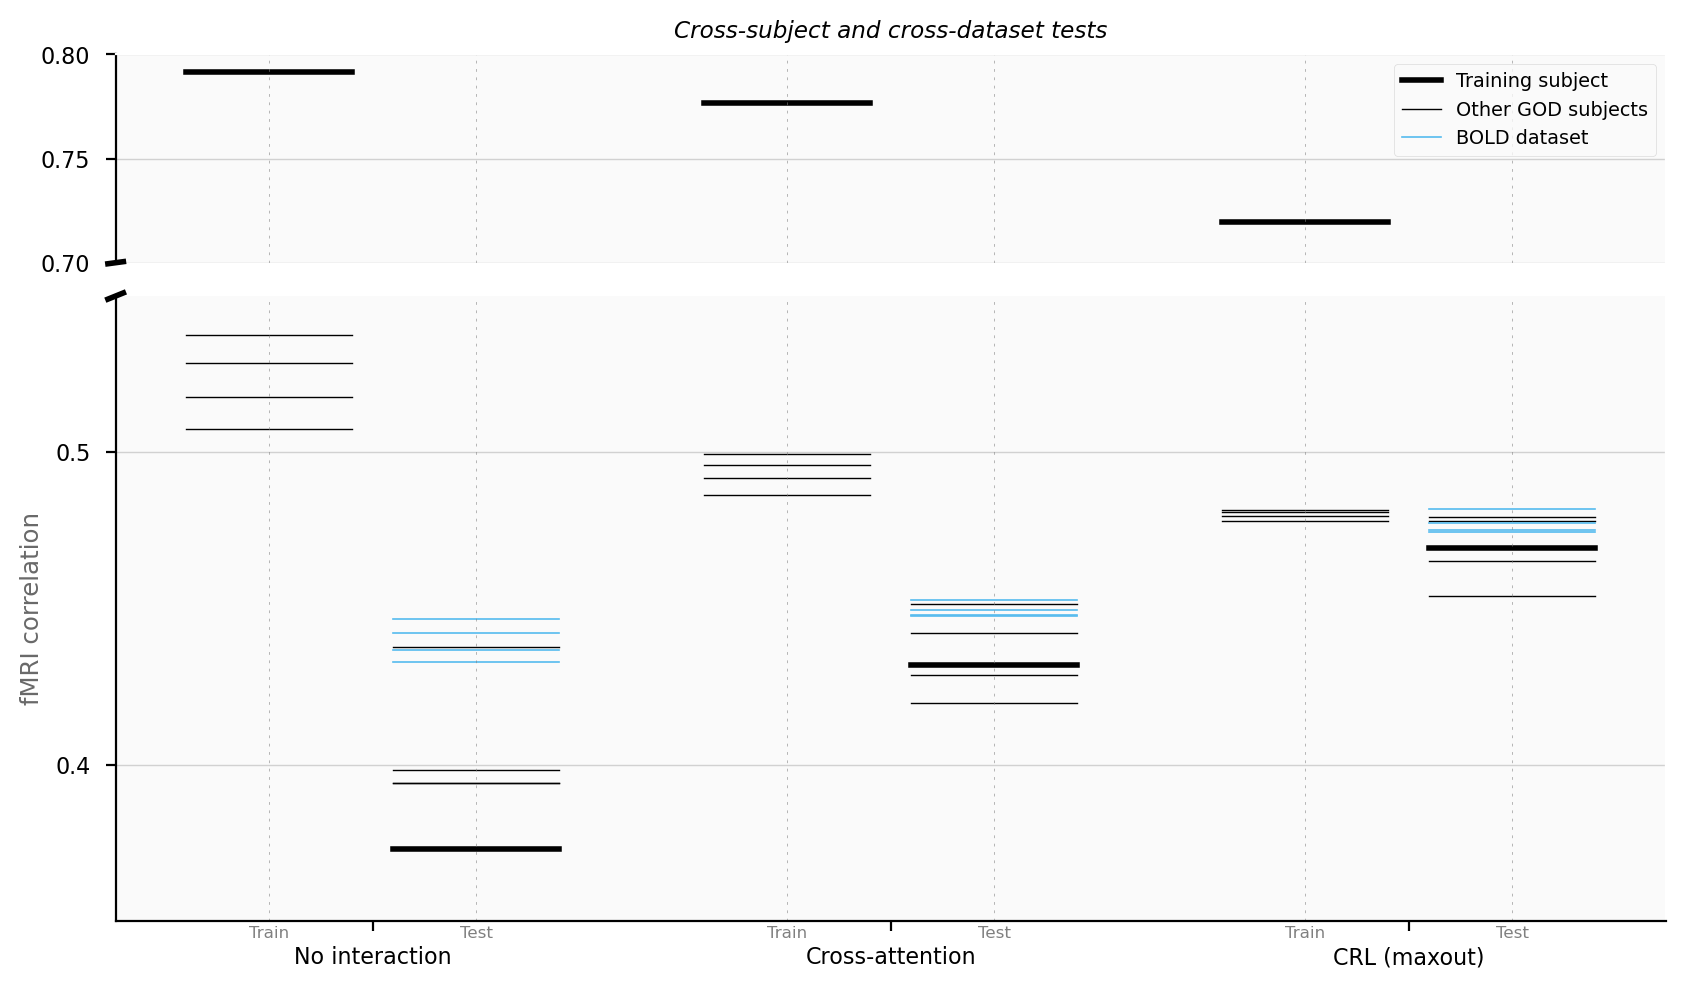

In [524]:
# scatter plot first two metrics

def plot_cross_subject(god, bold, horizontal, test=0, width=0.08):
    god_st_x, god_st_y = [m[test][0] for m in god], [m[test][1] for m in god]
    bold_st_x, bold_st_y = [m[test][0] for m in bold], [m[test][1] for m in bold]

    color = 'black'
    for i, e in enumerate(zip(god_st_x,god_st_y)):
        ax.plot([horizontal-width,horizontal+width], [e[0],e[0]], color=color, linestyle='-', linewidth=(2 if i == 0 else 0.5), label='a')
        ax2.plot([horizontal-width,horizontal+width], [e[0],e[0]], color=color, linestyle='-', linewidth=(2 if i == 0 else 0.5), label='a')
    if test == 1:
        tr_bold_st_x, tr_bold_st_y = [m[0][0] for m in bold], [m[0][1] for m in bold]
        for i, e in enumerate(zip(bold_st_x, bold_st_y, tr_bold_st_x, tr_bold_st_y)):
            e_value = ((5000-113)*e[0] + 113*e[2])/5000
            ax.plot([horizontal-width,horizontal+width], [e_value,e_value], color=get_color(8), linestyle='-', linewidth=0.6, label='a')
            ax2.plot([horizontal-width,horizontal+width], [e_value,e_value], color=get_color(8), linestyle='-', linewidth=0.6, label='a')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])

# plot the same data on both axes
plot_cross_subject(god_no, bold_no, 1)
plot_cross_subject(god_cr, bold_cr, 1.5)
plot_cross_subject(god_st, bold_st, 2)

plot_cross_subject(god_no, bold_no, 1.2, 1)
plot_cross_subject(god_cr, bold_cr, 1.7, 1)
plot_cross_subject(god_st, bold_st, 2.2, 1)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(.7, .8)  # outliers only
ax2.set_ylim(0.35, .55)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .005  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.sca(ax)
plt.title('Cross-subject and cross-dataset tests', style='italic', fontsize='x-small')

f.subplots_adjust(hspace=0.08)

# reduce number of y-axis ticks
ax.locator_params(axis='y', nbins=4)
ax2.locator_params(axis='y', nbins=4)

ax.grid(axis='y', linestyle='-', linewidth=0.5)
ax2.grid(axis='y', linestyle='-', linewidth=0.5)
ax.grid(axis='x', linestyle='-', linewidth=0.)
ax2.grid(axis='x', linestyle='-', linewidth=0.)

ax.spines['left'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.spines['bottom'].set_color('black')

ax.tick_params(bottom=False)

# add x-axis labels and a dashed vertical line going through the middle

plt.xticks([1.1,1.6,2.1], ['No interaction', 'Cross-attention', 'CRL (maxout)'])
for a in [ax, ax2]:
    for offset in [0,0.2]:
        a.axvline(1.+offset, color='grey', linestyle=(0, (5, 10)), linewidth=0.2)
        a.axvline(1.5+offset, color='grey', linestyle=(0, (5, 10)), linewidth=0.2)
        a.axvline(2.+offset, color='grey', linestyle=(0, (5, 10)), linewidth=0.2)

ax.text(1., 0.378, 'Train', ha='center', va='center', fontsize=6, color='grey')
ax.text(1.2, 0.378, 'Test', ha='center', va='center', fontsize=6, color='grey')

ax.text(1.5, 0.378, 'Train', ha='center', va='center', fontsize=6, color='grey')
ax.text(1.7, 0.378, 'Test', ha='center', va='center', fontsize=6, color='grey')

ax.text(2, 0.378, 'Train', ha='center', va='center', fontsize=6, color='grey')
ax.text(2.2, 0.378, 'Test', ha='center', va='center', fontsize=6, color='grey')

# add legend
handles, labels = ax2.get_legend_handles_labels()
# remove duplicates
new_handles_indices = [0,1,20]
new_handles = [handles[i] for i in new_handles_indices]
ax.legend(new_handles, ['Training subject', 'Other GOD subjects', 'BOLD dataset'], loc='upper right', fontsize='xx-small')
ax2.set_ylabel('fMRI correlation')
plt.show()

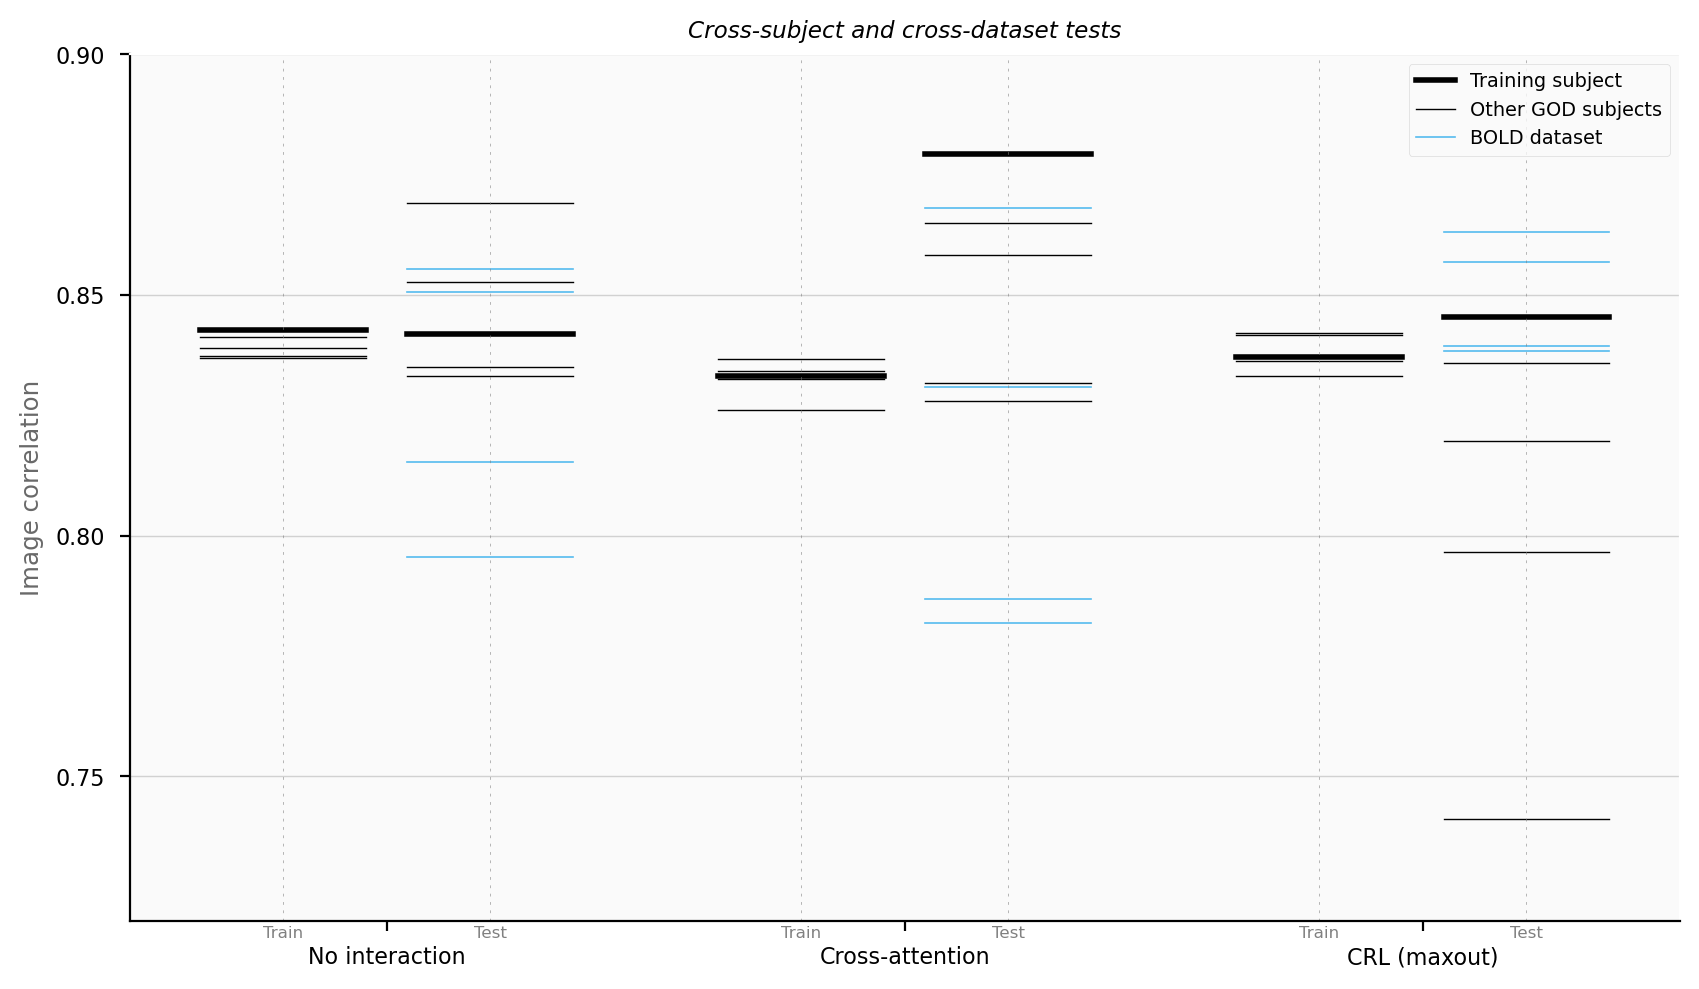

In [537]:
# scatter plot first two metrics

def plot_cross_subject(god, bold, horizontal, test=0, width=0.08):
    god_st_x, god_st_y = [m[test][0] for m in god], [m[test][1] for m in god]
    bold_st_x, bold_st_y = [m[test][0] for m in bold], [m[test][1] for m in bold]

    color = 'black'
    for i, e in enumerate(zip(god_st_x,god_st_y)):
        ax.plot([horizontal-width,horizontal+width], [e[1],e[1]], color=color, linestyle='-', linewidth=(2 if i == 0 else 0.5), label='a')
        ax2.plot([horizontal-width,horizontal+width], [e[1],e[1]], color=color, linestyle='-', linewidth=(2 if i == 0 else 0.5), label='a')
    if test == 1:
        tr_bold_st_x, tr_bold_st_y = [m[0][0] for m in bold], [m[0][1] for m in bold]
        for i, e in enumerate(zip(bold_st_x, bold_st_y, tr_bold_st_x, tr_bold_st_y)):
            e_value = ((5000-113)*e[1] + 113*e[3])/5000
            ax.plot([horizontal-width,horizontal+width], [e_value,e_value], color=get_color(8), linestyle='-', linewidth=0.6, label='a')
            ax2.plot([horizontal-width,horizontal+width], [e_value,e_value], color=get_color(8), linestyle='-', linewidth=0.6, label='a')

f, ax = plt.subplots()

# plot the same data on both axes
plot_cross_subject(god_no, bold_no, 1)
plot_cross_subject(god_cr, bold_cr, 1.5)
plot_cross_subject(god_st, bold_st, 2)

plot_cross_subject(god_no, bold_no, 1.2, 1)
plot_cross_subject(god_cr, bold_cr, 1.7, 1)
plot_cross_subject(god_st, bold_st, 2.2, 1)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(.72, 0.9)

# hide the spines between ax and ax2
ax.tick_params(labeltop=False)  # don't put tick labels at the top

plt.sca(ax)
plt.title('Cross-subject and cross-dataset tests', style='italic', fontsize='x-small')

# reduce number of y-axis ticks
ax.locator_params(axis='y', nbins=4)
ax.grid(axis='y', linestyle='-', linewidth=0.5)
ax.grid(axis='x', linestyle='-', linewidth=0.)

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.xticks([1.1,1.6,2.1], ['No interaction', 'Cross-attention', 'CRL (maxout)'])
for offset in [0,0.2]:
    ax.axvline(1.+offset, color='grey', linestyle=(0, (5, 10)), linewidth=0.2)
    ax.axvline(1.5+offset, color='grey', linestyle=(0, (5, 10)), linewidth=0.2)
    ax.axvline(2.+offset, color='grey', linestyle=(0, (5, 10)), linewidth=0.2)

ax.text(1., 0.7173, 'Train', ha='center', va='center', fontsize=6, color='grey')
ax.text(1.2, 0.7173, 'Test', ha='center', va='center', fontsize=6, color='grey')

ax.text(1.5, 0.7173, 'Train', ha='center', va='center', fontsize=6, color='grey')
ax.text(1.7, 0.7173, 'Test', ha='center', va='center', fontsize=6, color='grey')

ax.text(2, 0.7173, 'Train', ha='center', va='center', fontsize=6, color='grey')
ax.text(2.2, 0.7173, 'Test', ha='center', va='center', fontsize=6, color='grey')

# add legend
handles, labels = ax.get_legend_handles_labels()
# remove duplicates
new_handles_indices = [0,1,20]
new_handles = [handles[i] for i in new_handles_indices]
ax.legend(new_handles, ['Training subject', 'Other GOD subjects', 'BOLD dataset'], loc='upper right', fontsize='xx-small')
ax.set_ylabel('Image correlation')
plt.show()

#### Reconstruction from masked image (WIP)

Please first execute the model loading from the previous section

In [366]:
# get first item of the dataloader train[0]

item = next(iter(train[0]))
print(item['fmri'].shape, item['image'].shape)

torch.Size([16, 1, 4656]) torch.Size([16, 256, 256, 3])


In [368]:
item['image'] = item['image'].permute(0,3,1,2)

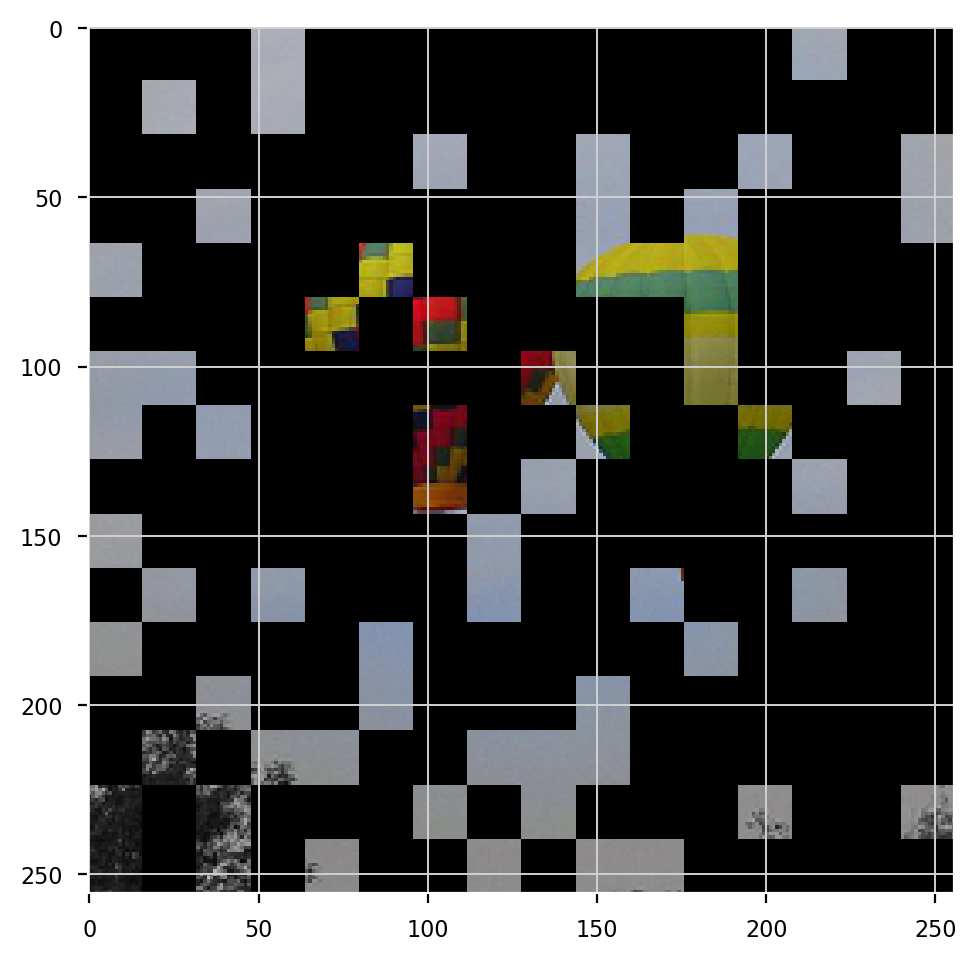

In [379]:
patched_image = model_image.patchify(item['image'])

masked_seq, mask, ids_restore = model_image.vit.embeddings.random_masking(patched_image, 0.75)

masked_image = torch.zeros([16, 256, 768])
masked_image[:, :64] = masked_seq[:, :]
# unshuffle to get the binary mask
masked_image = torch.gather(masked_image, dim=1, index=ids_restore.unsqueeze(-1).repeat(1,1,768))

unpatched_image = model_image.unpatchify(masked_image)

plt.imshow(unpatched_image[3].permute(1,2,0).numpy())

In [407]:
# pass the masked sequence through the model

img_prep = image_feature_extractor(images=item['image'], return_tensors="pt")
input = img_prep["pixel_values"].to(device)

with torch.no_grad():
    out = model_image(input)

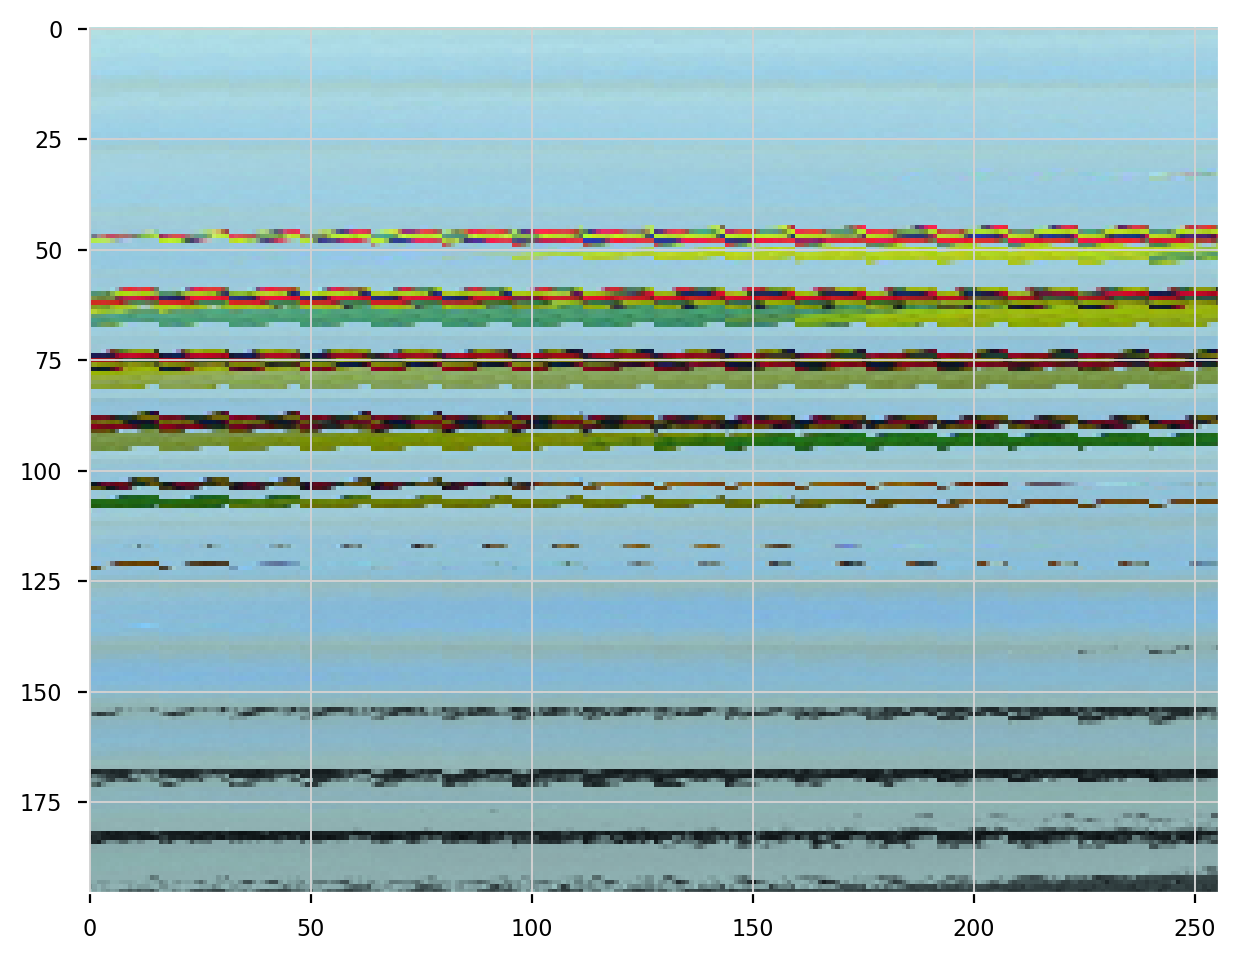

In [391]:
pat = model_image.patchify(input)

to_show = pat[3].cpu().numpy().reshape(196, 256, 3)
for i in range(3):
    to_show[:,:,i] = (to_show[:,:,i] - to_show[:,:,i].min()) / (to_show[:,:,i].max() - to_show[:,:,i].min())
    
plt.imshow(to_show)
plt.show()

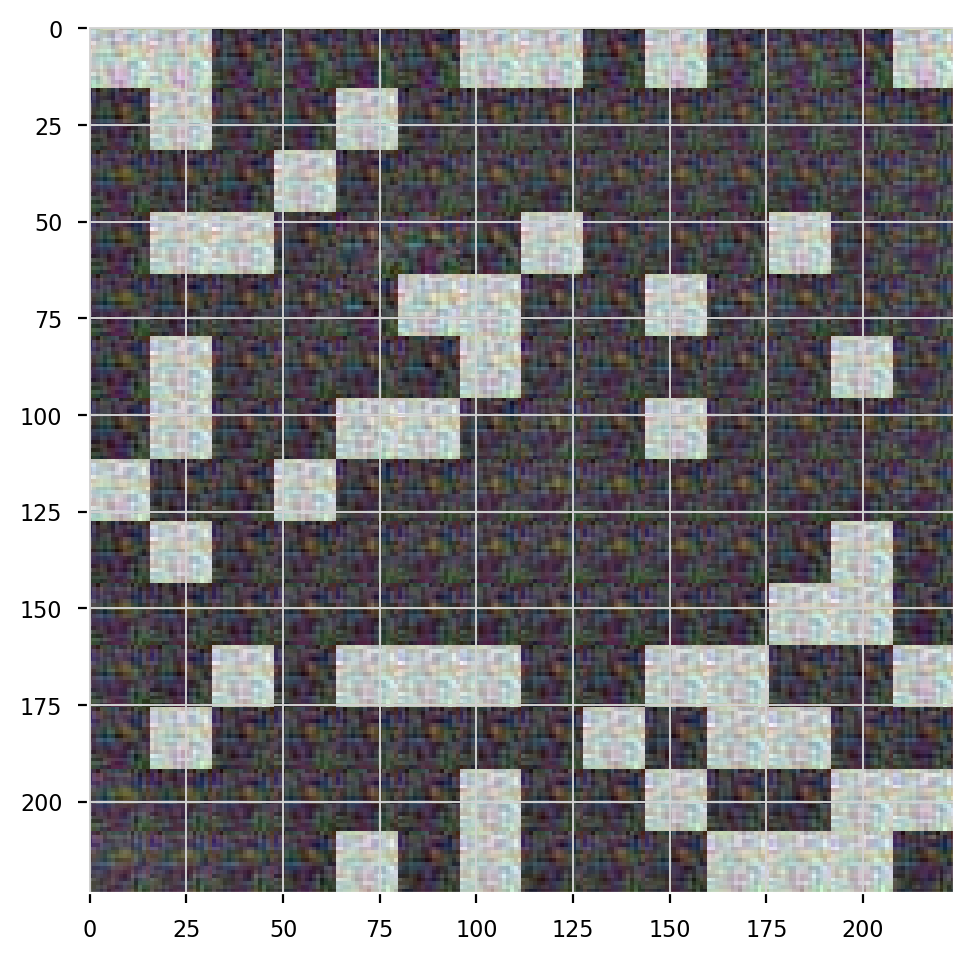

In [409]:
out_img = model_image.unpatchify(out.logits)

to_show = (out_img[3].permute(1,2,0).cpu().numpy())

# normalize the image to 0-1 independently for each channel

for i in range(3):
    to_show[:,:,i] = (to_show[:,:,i] - np.min(to_show[:,:,i])) / (np.max(to_show[:,:,i]) - np.min(to_show[:,:,i]))

plt.imshow(to_show)

In [412]:
out.loss[0]

tensor(0.4784, device='cuda:2')

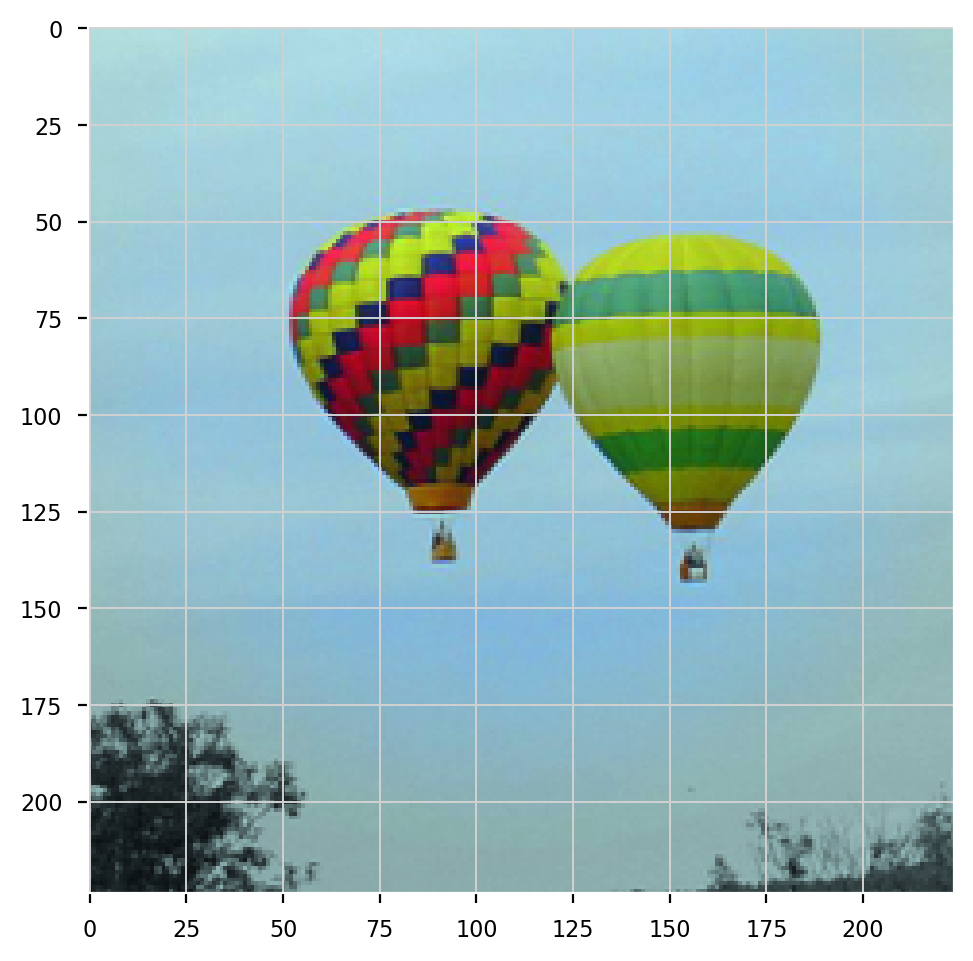

In [413]:
out_img = model_image.unpatchify(out.loss[1])

to_show = (out_img[3].permute(1,2,0).cpu().numpy())

# normalize the image to 0-1 independently for each channel

for i in range(3):
    to_show[:,:,i] = (to_show[:,:,i] - np.min(to_show[:,:,i])) / (np.max(to_show[:,:,i]) - np.min(to_show[:,:,i]))

plt.imshow(to_show)